In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path

In [ ]:
df = pd.read_csv('city_day.csv')

In [ ]:
# 0) Config
# ------------------------------
DATA_PATH = "city_day.csv"
MODEL_DIR = Path("models")
MODEL_DIR.mkdir(exist_ok=True)
# Expecting columns like: City, Date, AQI, AQIBucket, PM2.5, PM10, NO2, SO2, O3, CO

In [ ]:

# Fix common names
rename_map = {
    'AQIBucket': 'AQI_Bucket',
    'PM2.5': 'PM2_5',
}
df.rename(columns=rename_map, inplace=True)

In [ ]:
# Keep only required columns if present
expected_cols = ['City', 'Date', 'AQI', 'AQI_Bucket', 'PM2_5', 'PM10', 'NO2', 'SO2', 'O3', 'CO']
available = [c for c in expected_cols if c in df.columns]
missing = [c for c in expected_cols if c not in df.columns]
if missing:
    print(f"Warning: missing columns in dataset: {missing}")

df = df[available].copy()

In [ ]:
# Types & sort
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['City', 'Date']).reset_index(drop=True)

In [ ]:
# Fill forward within each city (common for AQI series)
for col in ['AQI', 'AQI_Bucket', 'PM2_5', 'PM10', 'NO2', 'SO2', 'O3', 'CO']:
    if col in df.columns:
        df[col] = df.groupby('City')[col].ffill()

In [ ]:
# Drop rows without target
df = df.dropna(subset=['AQI_Bucket'])

In [ ]:
# 2) Feature Engineering
# ------------------------------
# Seasonality
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek

In [ ]:
# Lags & rolling means per city
poll_cols = [c for c in ['PM2_5', 'PM10', 'NO2', 'SO2', 'O3', 'CO'] if c in df.columns]

for col in poll_cols + (['AQI'] if 'AQI' in df.columns else []):
    # 1-day lag
    df[f'{col}_lag1'] = df.groupby('City')[col].shift(1)
    # 3-day and 7-day rolling means (based on lagged to avoid leakage)
    df[f'{col}_3d_avg'] = df.groupby('City')[col].shift(1).rolling(window=3).mean()
    df[f'{col}_7d_avg'] = df.groupby('City')[col].shift(1).rolling(window=7).mean()

In [ ]:
# Ratios (guard against division by 0)
if 'PM2_5' in df.columns and 'PM10' in df.columns:
    df['PM25_to_PM10'] = df['PM2_5'] / df['PM10'].replace(0, np.nan)
if 'NO2' in df.columns and 'SO2' in df.columns:
    df['NO2_to_SO2'] = df['NO2'] / df['SO2'].replace(0, np.nan)

# Drop rows that became NaN due to lags/rolling at the start of each city
df = df.dropna().reset_index(drop=True)

In [ ]:
# 3) Train / Test split
# ------------------------------
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

target_col = 'AQI_Bucket'
feature_cols = [c for c in df.columns
                if c not in ['AQI_Bucket', 'Date', 'City']]

X = df[feature_cols]
y = df[target_col]

In [ ]:
# Encode target
le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

In [ ]:
# 4) Compute class weights (for balanced training)
# ------------------------------
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = {int(c): w for c, w in zip(classes, class_weights)}

# For LightGBM we prefer label->weight mapping by class name:
class_weight_by_label = {le.inverse_transform([k])[0]: v for k, v in class_weight_dict.items()}

In [ ]:
# Install if not available
!pip install imbalanced-learn

# Imports
from imblearn.combine import SMOTETomek
from collections import Counter

# Check original class distribution
print("Original training set class distribution:", Counter(y_train))

# Apply SMOTETomek only on training data
smt = SMOTETomek(random_state=42)
X_train_bal, y_train_bal = smt.fit_resample(X_train, y_train)

# Check new class distribution
print("Balanced training set class distribution:", Counter(y_train_bal))


Original training set class distribution: Counter({3: 5640, 1: 5630, 2: 1465, 0: 1200, 5: 909, 4: 396})
Balanced training set class distribution: Counter({4: 5640, 5: 5640, 0: 5638, 2: 5635, 3: 5490, 1: 5487})


In [ ]:
!pip install lightgbm

In [ ]:
!pip install xgboost


   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.3/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.5/56.8 MB 1.5 MB/s eta 0:00:37
    --------------------------------------- 1.0/56.8 MB 1.6 MB/s eta 0:00:35
    --------------------------------------- 1.3/56.8 MB 1.6 MB/s eta 0:00:34
   - -------------------------------------- 1.6/56.8 MB 1.5 MB/s eta 0:00:37
   - -------------------------------------- 1.8/56.8 MB 1.4 MB/s eta 0:00:40
   - -------------------------------------- 2.1/56.8 MB 1.4 MB/s eta 0:00:39
   - -------------------------------------- 2.4/56.8 MB 1.4 MB/s eta 0:00:38
   - -------------------------------------- 2.6/56.8 MB 1.4 MB/s eta 0:00:38
   -- ------------------------------------- 2.9/56.8 MB 1.5 MB/s eta 0:00:37
   -- ------------------------------------- 3.1/56.8 MB 1.5 MB/s eta 0:00:37
   -- ------------------------------------- 3.4/56.8 MB 1.4 MB/s eta 0:00:38
   -- -------

In [ ]:
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# 5) Train a primary model (LightGBM), with fallbacks
# =========================
best_model = None
best_acc = 0
best_name = None

try:
    print("Training LightGBM...")
    lgb_model = lgb.LGBMClassifier(
        boosting_type='gbdt',
        num_leaves=31,
        learning_rate=0.05,
        n_estimators=100,
        verbosity=-1  # Suppress LightGBM training logs
    )
    lgb_model.fit(X_train, y_train)
    y_pred = lgb_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"LightGBM Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    best_model, best_acc, best_name = lgb_model, acc, "LightGBM"

except Exception as e:
    print(f"LightGBM failed: {e}")

# Fallback 1: Random Forest
try:
    print("\nTraining Random Forest...")
    rf_model = RandomForestClassifier(
        n_estimators=200, random_state=42
    )
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Random Forest Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    if acc > best_acc:
        best_model, best_acc, best_name = rf_model, acc, "Random Forest"

except Exception as e:
    print(f"Random Forest failed: {e}")

# Fallback 2: XGBoost
try:
    print("\nTraining XGBoost...")
    xgb_model = XGBClassifier(
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42
    )
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"XGBoost Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    if acc > best_acc:
        best_model, best_acc, best_name = xgb_model, acc, "XGBoost"

except Exception as e:
    print(f"XGBoost failed: {e}")


Training LightGBM...
LightGBM Accuracy: 0.9992
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       300
           1       1.00      1.00      1.00      1407
           2       1.00      1.00      1.00       367
           3       1.00      1.00      1.00      1410
           4       0.98      0.99      0.98        99
           5       1.00      0.99      0.99       227

    accuracy                           1.00      3810
   macro avg       1.00      1.00      1.00      3810
weighted avg       1.00      1.00      1.00      3810


Training Random Forest...
Random Forest Accuracy: 0.9966
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       300
           1       1.00      1.00      1.00      1407
           2       0.99      0.99      0.99       367
           3       1.00      1.00      1.00      1410
           4       0.98      0.98      0.98        99
           5       0.99    

In [ ]:
# 6) Evaluation
# ------------------------------
from sklearn.metrics import classification_report
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

# ------------------------------
# 7) Predict today's AQI bucket per city (latest row)
# ------------------------------
# Build the same features on the full df to pick each city's latest feature row
# (We already did feature engineering above; just take the last per city.)
latest_feat = df.sort_values(['City', 'Date']).groupby('City').tail(1).copy()

latest_feat['Predicted_Bucket_idx'] = best_model.predict(latest_feat[feature_cols])
latest_feat['Predicted_Bucket'] = le.inverse_transform(latest_feat['Predicted_Bucket_idx'])

              precision    recall  f1-score   support

        Good       1.00      1.00      1.00       300
    Moderate       1.00      1.00      1.00      1407
        Poor       1.00      1.00      1.00       367
Satisfactory       1.00      1.00      1.00      1410
      Severe       0.98      0.99      0.98        99
   Very Poor       1.00      0.99      0.99       227

    accuracy                           1.00      3810
   macro avg       1.00      1.00      1.00      3810
weighted avg       1.00      1.00      1.00      3810



In [ ]:
# 8) Personalized Alerts
# ------------------------------
user_data = pd.DataFrame({
    'Name': ['Sakshi', 'Ravi', 'Priya', 'Amit', 'Neha'],
    'Age': [25, 60, 12, 40, 55],
    'Condition': ['Healthy', 'Asthma', 'Healthy', 'COPD', 'Asthma'],
    'City': ['Delhi', 'Delhi', 'Delhi', 'Delhi', 'Delhi']
})

def get_risk_level(age, condition):
    condition = str(condition).lower()
    if condition in ['asthma', 'copd'] or age < 15 or age > 55:
        return 'High'
    return 'Low'

user_data['Risk_Level'] = user_data.apply(lambda r: get_risk_level(r['Age'], r['Condition']), axis=1)

In [ ]:
def get_recommendation(aqi_bucket, risk_level):
    recs = {
        'Good': {
            'Low': "All clear — enjoy outdoor activities.",
            'High': "All clear — enjoy outdoor activities."
        },
        'Satisfactory': {
            'Low': "Safe to go out; stay aware of changes.",
            'High': "Safe to go out; monitor symptoms."
        },
        'Moderate': {
            'Low': "Safe for most, avoid heavy outdoor exercise.",
            'High': "Limit outdoor activities."
        },
        'Poor': {
            'Low': "Reduce prolonged outdoor activity.",
            'High': "Stay indoors if possible."
        },
        'Very Poor': {
            'Low': "Avoid going outside.",
            'High': "Avoid all outdoor exposure; wear a mask."
        },
        'Severe': {
            'Low': "Avoid going outside.",
            'High': "Avoid all outdoor exposure; wear a mask."
        }
    }
    return recs.get(aqi_bucket, {}).get(risk_level, "No guidance available.")

alerts = []
for _, u in user_data.iterrows():
    row = latest_feat[latest_feat['City'] == u['City']]
    if row.empty:
        continue
    aqi_bucket_pred = row['Predicted_Bucket'].values[0]
    date_value = row['Date'].values[0]
    date_str = pd.to_datetime(date_value).strftime('%Y-%m-%d')
    rec = get_recommendation(aqi_bucket_pred, u['Risk_Level'])
    msg = f"Hello {u['Name']}, today ({date_str}) the predicted AQI in {u['City']} is {aqi_bucket_pred}. {rec}"
    alerts.append(msg)


In [ ]:
print("\n--- Personalized Alerts ---")
for m in alerts:
    print(m)


--- Personalized Alerts ---
Hello Sakshi, today (2020-07-01) the predicted AQI in Delhi is Moderate. Safe for most, avoid heavy outdoor exercise.
Hello Ravi, today (2020-07-01) the predicted AQI in Delhi is Moderate. Limit outdoor activities.
Hello Priya, today (2020-07-01) the predicted AQI in Delhi is Moderate. Limit outdoor activities.
Hello Amit, today (2020-07-01) the predicted AQI in Delhi is Moderate. Limit outdoor activities.
Hello Neha, today (2020-07-01) the predicted AQI in Delhi is Moderate. Limit outdoor activities.


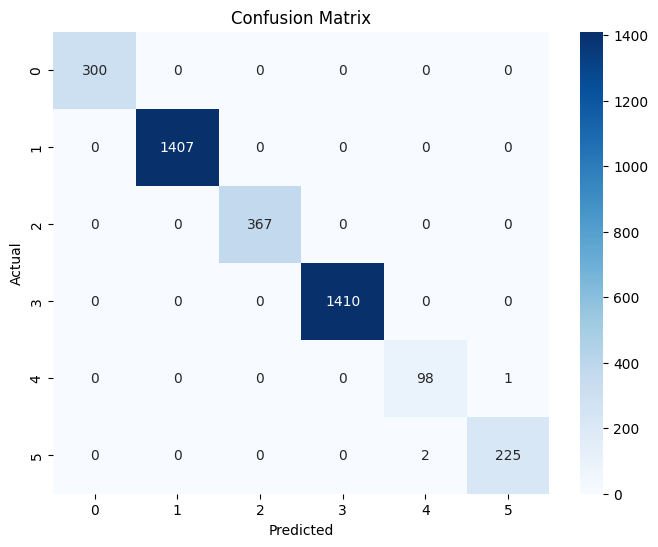

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
classes = np.unique(y_test)  # works for NumPy arrays

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
